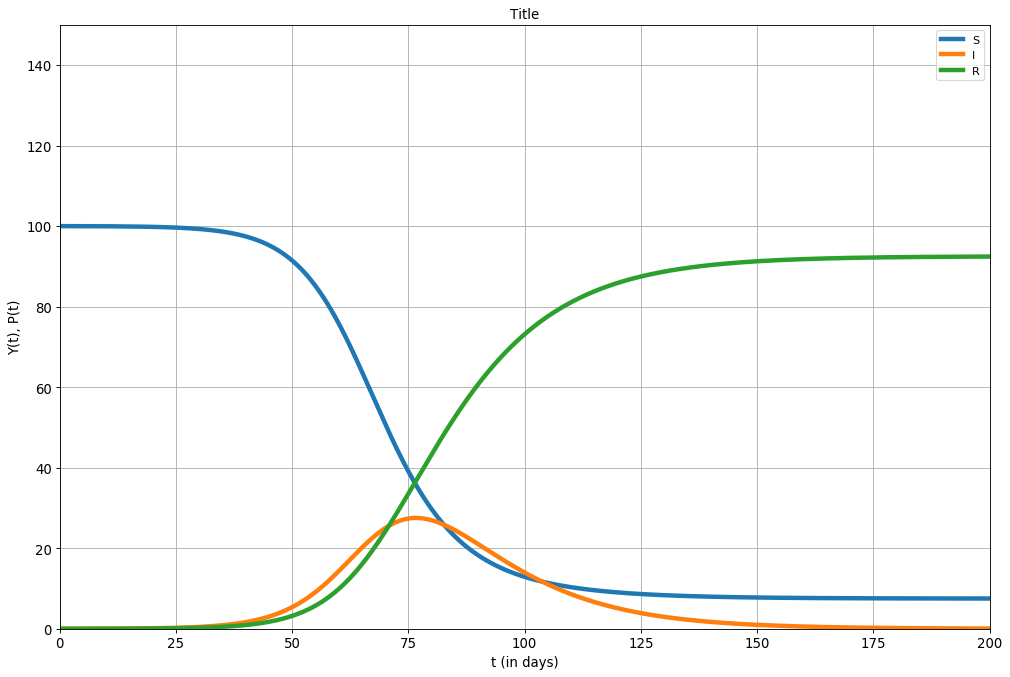

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

import scipy.stats


Dt = 0.01               # timestep Delta t
 
S_start=100 #healthy but can be infected 
I_start=0.01 #infectious
R_start=0 #recovered

N=S_start+I_start+R_start
#mu 
# beta is avg contact and gamma - recovery rate, gamma is kinda fixed

beta,gamma= 0.2,1/14
            
t_start = 0             # starttime
t_end = 200              # endtime
n_steps = int(round((t_end-t_start)/Dt))    # number of timesteps


S_arr = np.zeros(n_steps +1)
I_arr = np.zeros(n_steps +1)
R_arr=np.zeros(n_steps +1)

t_arr = np.zeros(n_steps + 1) 

t_arr[0] = t_start    

S_arr[0] =S_start   
I_arr[0]=I_start
R_arr[0]=R_start


# Euler's method
for i in range (1, n_steps + 1):  
       
        S = S_arr[i-1]
        I = I_arr[i-1]
        R = R_arr[i-1]
        t = t_arr[i-1]
        
        dSdt = -beta*I*S/N          # calculate the derivative of 
        dIdt=beta*I*S/N -gamma*I
        dRdt=gamma*I
        #dRdt=-dSdt-dEdt-dIdt
        
        S_arr[i] = S + Dt*dSdt  # calc.  at next timestep,add to array
        I_arr[i] = I + Dt*dIdt
        R_arr[i] = R + Dt*dRdt
        t_arr[i] = t + Dt       # add new value of t to array
        
# plotting the result
fig = plt.figure(figsize=(15, 10), dpi=80)                                  # create figure
plt.plot(t_arr, S_arr, linewidth = 4, label = 'S')    # plot Y to t 

plt.plot(t_arr, I_arr, linewidth = 4, label = 'I') 
plt.plot(t_arr, R_arr, linewidth = 4, label = 'R') 
plt.title('Title', fontsize = 12)    
plt.xlabel('t (in days)', fontsize = 12)
plt.ylabel('Y(t), P(t)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)                        # show grid
plt.axis([t_start, t_end, 0, 150])     # show axes measures
plt.legend()
plt.show()


In [2]:
def get_inf(beta,scale,duration, gamma = 1/14):
    Dt = 0.01               # timestep Delta t
    S_start=99.9 #healthy but can be infected 
    I_start=0.01 #infectious
    R_start=0 #recovered

    N=S_start+I_start+R_start
    #mu 
    # beta is avg contact and gamma - recovery rate, gamma is kinda fixed


    t_start = 0#loc    
    t_end = duration #+loc             endtime
    n_steps = int(round((t_end-t_start)/Dt))    # number of timesteps


    S_arr = np.zeros(n_steps +1)
    I_arr = np.zeros(n_steps +1)
    R_arr=np.zeros(n_steps +1)

    t_arr = np.zeros(n_steps + 1) 

    t_arr[0] = t_start    

    S_arr[0] =S_start   
    I_arr[0]=I_start
    R_arr[0]=R_start


    # Euler's method
    for i in range (1, n_steps + 1):  

            S = S_arr[i-1]
            I = I_arr[i-1]
            R = R_arr[i-1]
            t = t_arr[i-1]

            dSdt = -beta*I*S/N          # calculate the derivative of 
            dIdt=beta*I*S/N -gamma*I
            dRdt=gamma*I
            #dRdt=-dSdt-dEdt-dIdt

            S_arr[i] = S + Dt*dSdt  # calc.  at next timestep,add to array
            I_arr[i] = I + Dt*dIdt
            R_arr[i] = R + Dt*dRdt
            t_arr[i] = t + Dt   # add new value of t to array
            
          
    return I_arr*scale

In [3]:
def movavg(data):
    return [np.mean(data[i-7:i]) for i in range(7,len(data))]

In [28]:

df = pd.read_csv(r"C:\Users\Dima\Downloads\WHO-COVID-19-global-data.csv")
df
italy = df[df['Country']=='Italy']

italy.describe()


,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,463.000000,4.630000e+02,463.000000,463.000000
mean,8029.377970,9.312055e+05,243.760259,42823.974082
std,9859.920841,1.129278e+06,252.465387,31979.677499
min,-148.000000,0.000000e+00,-31.000000,0.000000
25%,319.000000,1.985445e+05,11.000000,26810.500000
50%,2499.000000,2.561180e+05,162.000000,35418.000000
75%,14302.500000,1.849724e+06,441.000000,64765.500000
max,40902.000000,3.717602e+06,993.000000,112861.000000


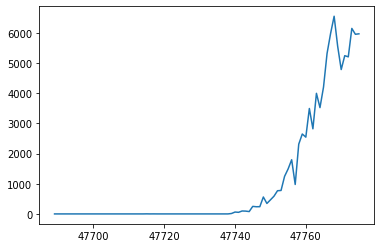

In [5]:
# part with no measures, so till they are intoduced + 2 weeks
plt.plot(italy[0:87]['New_cases'])

 That's a complex because we kinda don't have explanattory variables So we do $y = f(\beta)+\epsilon$, where $f(\beta)$ set of points of infected people for possible set of parameteres. And y is the actual number of infected people, and well, we'll just minimise SSR over $\beta$. We dont estime $\gamma$ - because it's known

In [25]:
def get_SSR(x):
        beta = x[0]
        scale = x[1]
        start = x[2]
        end=x[3]
        cases = italy['New_cases'][int(start):int(end)].values

        cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases ))

        num_inf = movavg(cases) #maybe allow for moving dates 
        theory_num = get_inf(beta=beta,scale=scale,duration=len(num_inf), gamma = 1/14)
        theory_num=theory_num[::100][1:]

        return  (np.sum([(num_inf[i]-theory_num[i])**2 for i in range(len(num_inf))]))
    
    

def do_all(start_values=[0,20],end_values=[87,97]):

    
    from scipy.optimize import minimize
    from scipy.optimize import Bounds


    bounds = Bounds((0, 0, start_values[0], end_values[1] ), (1.0, 0.03, start_values[1],end_values[1]))
    result = minimize(get_SSR, x0=[0.3,0.05,(start_values[0]+start_values[1])/2,(end_values[0]+end_values[1])/2],method='L-BFGS-B', bounds = bounds)
    print(result)


    fig = plt.figure(figsize=(15, 10), dpi=80) 


    opt_param = result['x']

    cases = italy['New_cases'][int(opt_param[2]):int(opt_param[3])].values
    cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases ))

    plt.plot(range(len(movavg(cases))) ,movavg(cases), linewidth = 4)

    theory_num = get_inf(beta=opt_param[0],scale=opt_param[1],duration=-int(opt_param[2])+int(opt_param[3]))
    x=theory_num[::100][1:]
    
    
   #plt.title('Figure 3. Fitted curve and weekly moving average for Italy no measures', fontsize = 20)    
    #plt.xlabel('time (in days)', fontsize = 20)
    #plt.ylabel('share of infections', fontsize = 20)
    plt.plot(x,linewidth = 4 )
    plt.show()

    residuals = [(movavg(cases)[i] - x[i]) for i in range(len(movavg(cases)))]

    SSR = np.sum([i**2 for i in residuals])
    print('SSR '+str(SSR))
    pearson_chisq= np.sum([((movavg(cases)[i] - x[i])/ x[i])**2 for i in range(len(movavg(cases)))])
    print('pearson_chisq ' + str(pearson_chisq))
    #GTest = 2* np.sum([movavg(cases)[i]*np.log(movavg(cases)[i]/x[i]) for i in range(len(movavg(cases)))])
    #print("GTest " + str(GTest))
    return opt_param


We'll use chow test to see if we can estimate model on parts with no restrictions to forecast part with restrictions $F = \frac {SSR_0-SS1_1 / n_2}{SSR_1/n1-k}$, where SSR1 is a fit for full model, SSR0 is a fit for part with no measures. We do our optimisation on part with no measures and big regression is part with no measures + 50 points
No 

      fun: 0.19126138776791848
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.72597525e-06, 4.49223991e-05, 0.00000000e+00, 0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 310
      nit: 9
   status: 0
  success: True
        x: array([2.03841519e-01, 2.92739854e-02, 1.00000000e+01, 9.50000000e+01])


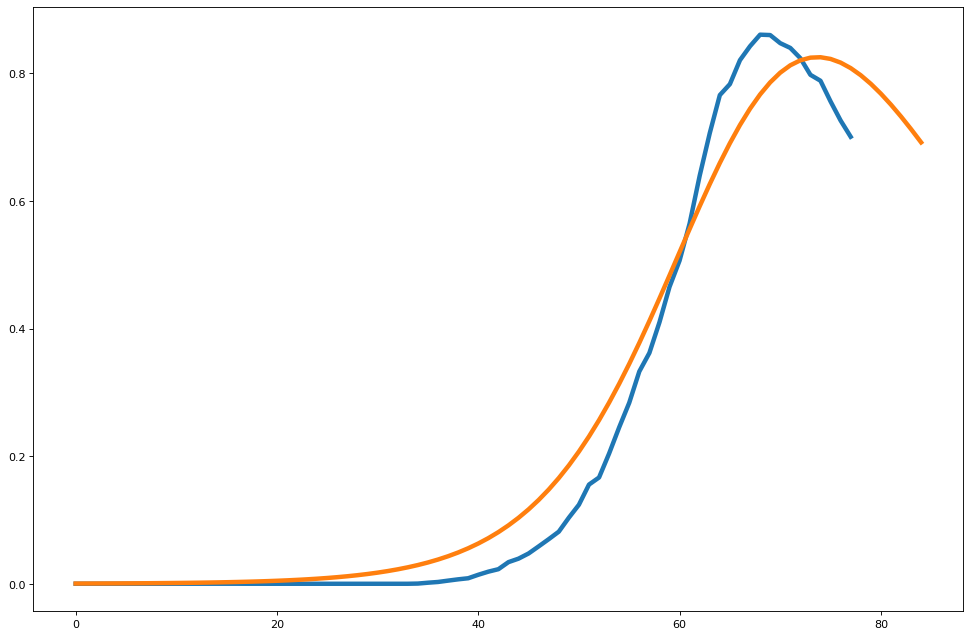

SSR 0.19126138776791848
pearson_chisq 43.098520565520595
      fun: 0.2861724057529729
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.38777878e-07, -1.11022302e-08,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 195
      nit: 10
   status: 0
  success: True
        x: array([2.04496594e-01, 2.83138973e-02, 1.00000000e+01, 1.45000000e+02])


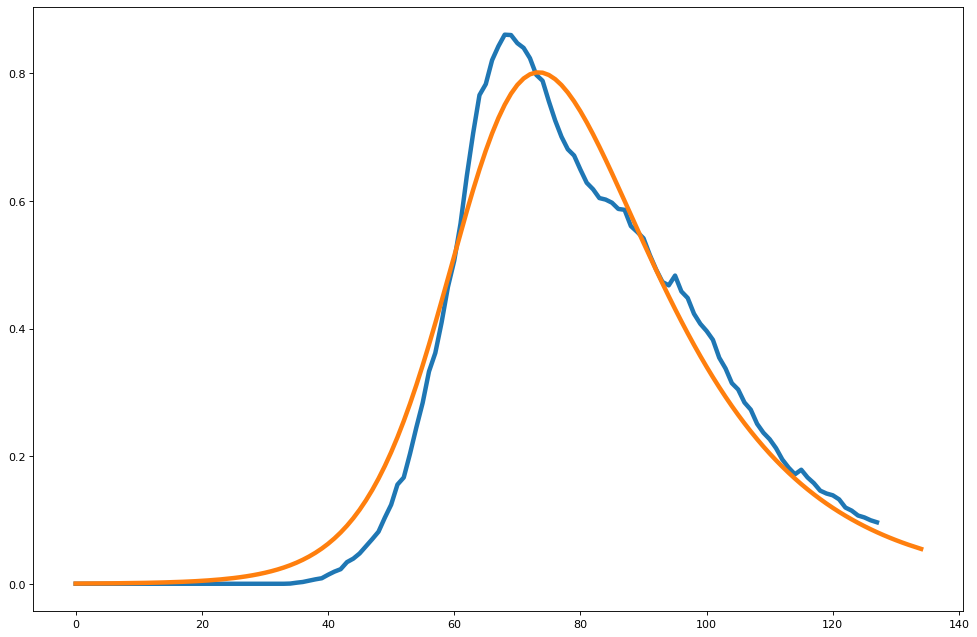

SSR 0.2861724057529729
pearson_chisq 43.75921984355237
the beta change moving from no measures to model with measures is 0.0006550745647007084
Chow forecast test statistics is 176.63332198791295
Critical value is 1.4470567669033696


In [26]:
def get_summary():
    p_0 = do_all(start_values=[0,20],end_values=[85,95])
    p_1 = do_all(start_values=[0,20],end_values=[85+50,95+50])
    SSR_1 = get_SSR(p_1)
    SSR_0 = get_SSR([p_0[1],p_0[1],p_0[2],p_1[3]-p_1[2]])
    
    print('the beta change moving from no measures to model with measures is '+ str(p_1[0]-p_0[0]))
    F = (SSR_0-SSR_1)/(p_1[3]-p_1[2] - p_0[3]+p_0[2]) / (SSR_1 /(p_1[3]-p_1[2]-3) )
    print('Chow forecast test statistics is ' + str(F))
    print('Critical value is ' + str(scipy.stats.f.ppf(0.95,(p_1[3]-p_1[2] - p_0[3]+p_0[2]) ,(p_1[3]-p_1[2]-3))))
    
get_summary()